In [1]:
from IPython import get_ipython

import numpy as np
import optuna
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("seaborn")


from sklearn.metrics import mean_absolute_percentage_error

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader


import os
import sys

sys.path.append("..")

from src.data.dataset import SequenceDataset
from src.optim.early_stopping import EarlyStopping
from src.models.transformer import Transformer
from src.model_selection.objective import split_train_test, TransformerObjective

## Load data

In [2]:
root_path = ""
if 'google.colab' in str(get_ipython()):
    root_path = "/content/drive/MyDrive/data/"
else:
    root_path = "../data/"

In [3]:
name = "load"

data = pd.read_pickle(f"{root_path}preprocessed/{name}.pkl")

X, y = data["S_TOT"].to_frame(), data["S_TOT"]
X_train, y_train, X_val, y_val, X_test, y_test = split_train_test(X, y)

X.shape: (105215, 1)
X_train.shape: (35040, 1), y_train.shape: (35040,)
X_val.shape: (35040, 1), y_val.shape: (35040,)
X_test.shape: (35135, 1), y_test.shape: (35135,)


In [4]:
seq_length_input = 96 * 3
seq_length_output = 96
batch_size = 128

training_data = SequenceDataset(
    X=X_train,
    y=y_train,
    seq_length_input=seq_length_input,
    seq_length_prediction=seq_length_output,
)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False)

val_data = SequenceDataset(
    X=X_val,
    y=y_val,
    seq_length_input=seq_length_input,
    seq_length_prediction=seq_length_output,
)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

test_data = SequenceDataset(
    X=X_test,
    y=y_test,
    seq_length_input=seq_length_input,
    seq_length_prediction=seq_length_output,
)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Manual search

In [5]:
epochs = 1
lr = 3e-4
weight_decay = 0.001
dropout = 0
num_features = X_train.shape[1]
hidden_units = 8
num_layers = 2
n_heads = 8

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model to device
model = Transformer(
    num_features=num_features,
    dec_seq_len=seq_length_input,
    max_seq_len=seq_length_input,
    out_seq_len=seq_length_output,
    dim_val=hidden_units,
    n_encoder_layers=4,
    n_decoder_layers=4,
    n_heads=8,
    dropout_encoder=0.2,
    dropout_decoder=0.2,
    dropout_pos_enc=0.2,
    dim_feedforward_encoder=hidden_units,
    dim_feedforward_decoder=hidden_units,
).to(device)

# Generate the optimizers
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# mean squared error
criterion = nn.MSELoss()

# keep track of val loss and do early stopping
early_stopping = EarlyStopping(patience=5)

train_history, test_history = [], []

for epoch in range(epochs):

    # perform training
    loss_in_epoch_train = 0

    model.train()

    for inputs, targets in train_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        # reset the gradients back to zero PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        outputs = model(inputs, targets)

        train_loss = criterion(outputs, targets)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss_in_epoch_train += train_loss.item()

        # Decay Learning Rate
        # scheduler.step()

    model.eval()

    loss_in_epoch_test = 0

    with torch.no_grad():
        for inputs, targets in val_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs, targets)

            test_loss = criterion(outputs, targets)
            loss_in_epoch_test += test_loss.item()

    train_loss = loss_in_epoch_train / len(train_loader)
    test_loss = loss_in_epoch_test / len(val_loader)

    train_history.append(train_loss)
    test_history.append(test_loss)

    print(f"epoch : {epoch + 1}/{epochs},", end=" ")
    print(f"loss (train) = {train_loss:.8f}, loss (test) = {test_loss:.8f}")

    # return early if val loss doesn't decrease for several iterations
    early_stopping(test_loss)
    if early_stopping.early_stop:
        break


# Save model for each trial
torch.save(
    model.state_dict(),
    f"../models/{model.__class__.__name__}_{name}_manual.pth",
)


epoch : 1/1, loss (train) = 0.92425726, loss (test) = 0.62706470


Text(0, 0.5, 'MSE')

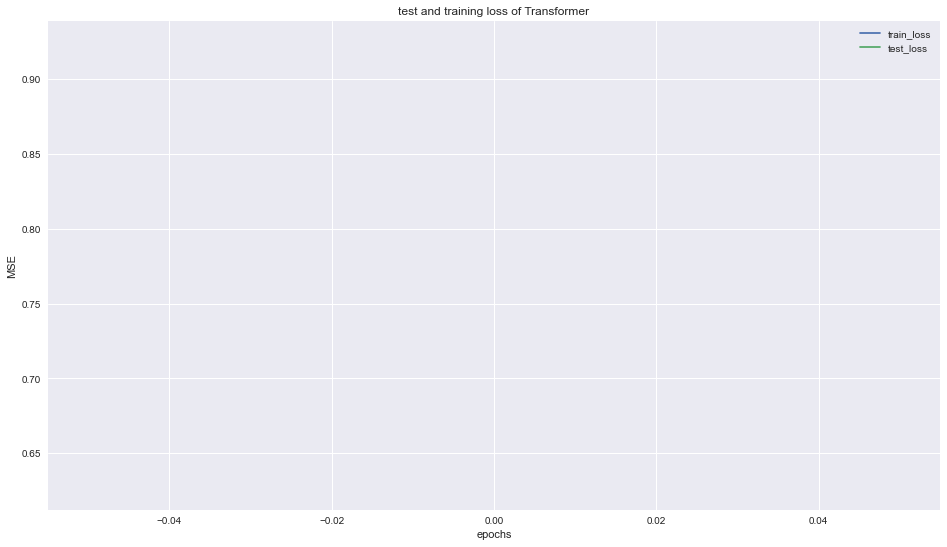

In [6]:
results = pd.DataFrame({"train_loss": train_history, "test_loss": test_history})
results.index.name = "epochs"

ax = results.plot(
    title=f"test and training loss of {model.__class__.__name__}", figsize=(16, 9)
)
ax.set_ylabel("MSE")


<AxesSubplot:title={'center':'ground truth vs. prediction'}, xlabel='date'>

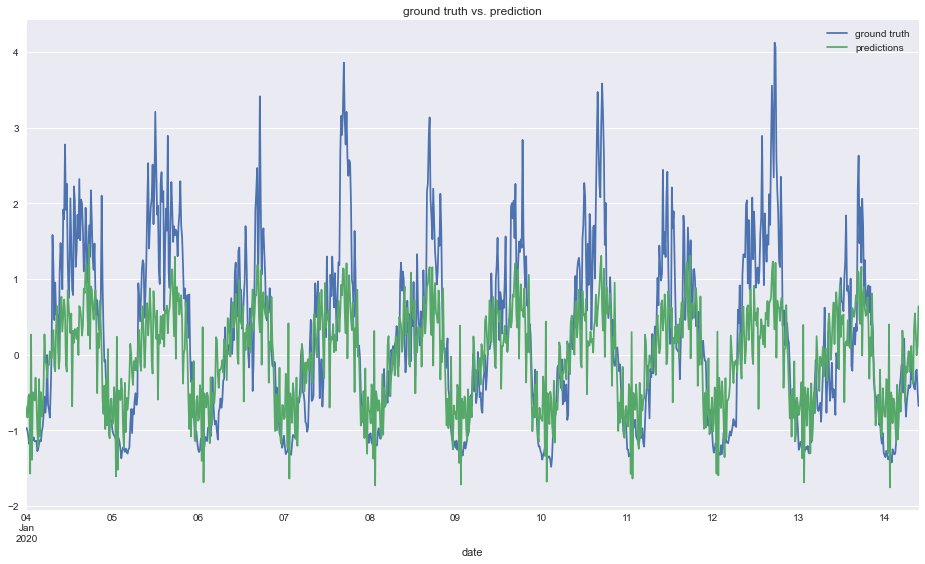

In [7]:
# make predictions with final model
predictions_all, targets_all = [], []

model.eval()

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    prediction = model(inputs, targets)
    predictions_all.append(prediction.detach().cpu().numpy().flatten())
    targets_all.append(targets.numpy().flatten())

predictions_all = np.concatenate(predictions_all)
targets_all = np.concatenate(targets_all)

results = pd.DataFrame(
    {"ground truth": targets_all, "predictions": predictions_all},
    index=X_test.index[seq_length_input-1:],
)
results.head(1000).plot(title="ground truth vs. prediction", figsize=(16, 9))


<AxesSubplot:title={'center':'MAPE in % over time'}, xlabel='date', ylabel='MAPE in %'>

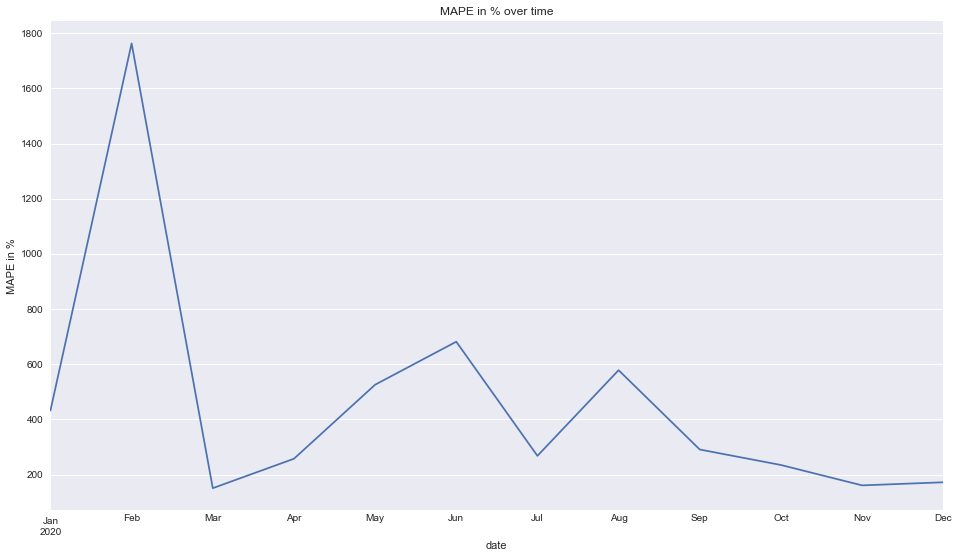

In [8]:
mape_model = (
    results.groupby(pd.Grouper(freq="M"))[["ground truth", "predictions"]].apply(
        lambda x: mean_absolute_percentage_error(x["ground truth"], x["predictions"])
    )
    * 100
)

mape_model.plot(ylabel="MAPE in %", title="MAPE in % over time", figsize=(16, 9))

## Bayesian search
Bayesian search build on top of [optuna](https://optuna.org/).

In [9]:
N_TRIALS = 4

default_params = {
    "lr": 3e-4,
    "hidden_units": 8,
    "num_layers": 4,
    "batch_size": 128,
}

study = optuna.create_study(direction="minimize")
objective = TransformerObjective(X, y, name)

# use default params from manual trial
study.enqueue_trial(default_params)

study.optimize(objective, n_trials=N_TRIALS)

optimized_params = study.best_trial.params
print(f"params: {optimized_params}")
print(f"no: {study.best_trial.number}")

study_df = study.trials_dataframe()
study_df.to_csv(f"../docs/study_transformer_{name}_all_parameters.csv")

[I 2022-07-23 07:08:41,504] A new study created in memory with name: no-name-e1caaab9-065d-4330-9a07-1923666f06d6
C:\Users\Markus\AppData\Local\Temp\ipykernel_2020\2819351525.py:14: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(default_params)


X.shape: (105215, 1)
X_train.shape: (35040, 1), y_train.shape: (35040,)
X_val.shape: (35040, 1), y_val.shape: (35040,)
X_test.shape: (35135, 1), y_test.shape: (35135,)


c:\Users\Markus\anaconda3\envs\bda\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
c:\Users\Markus\anaconda3\envs\bda\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


epoch : 1/1, loss (train) = 1.11518361, loss (test) = 0.76800758


[I 2022-07-23 07:12:51,100] Trial 0 finished with value: 15.757733345031738 and parameters: {'batch_size': 128, 'hidden_units': 8, 'num_layers': 4, 'lr': 0.0003}. Best is trial 0 with value: 15.757733345031738.


epoch : 1/1, loss (train) = 4.98434258, loss (test) = 198.92663574


[I 2022-07-23 07:19:12,085] Trial 1 finished with value: 1.3066213130950928 and parameters: {'batch_size': 256, 'hidden_units': 16, 'num_layers': 4, 'lr': 0.011881722831993622}. Best is trial 1 with value: 1.3066213130950928.


epoch : 1/1, loss (train) = 6.64946187, loss (test) = 4.46495557


[I 2022-07-23 07:25:27,892] Trial 2 finished with value: 3.349370241165161 and parameters: {'batch_size': 256, 'hidden_units': 32, 'num_layers': 5, 'lr': 0.0022473471120916843}. Best is trial 1 with value: 1.3066213130950928.


epoch : 1/1, loss (train) = 1.27078081, loss (test) = 1.10209792


[I 2022-07-23 07:25:55,298] Trial 3 finished with value: 10.210389137268066 and parameters: {'batch_size': 32, 'hidden_units': 24, 'num_layers': 1, 'lr': 1.2436278701602663e-05}. Best is trial 1 with value: 1.3066213130950928.


params: {'batch_size': 256, 'hidden_units': 16, 'num_layers': 4, 'lr': 0.011881722831993622}
no: 1


C:\Users\Markus\AppData\Local\Temp\ipykernel_2020\3166378494.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\Markus\AppData\Local\Temp\ipykernel_2020\3166378494.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
C:\Users\Markus\AppData\Local\Temp\ipykernel_2020\3166378494.py:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(
[W 2022-07-23 07:25:56,896] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot:ylabel='batch_size'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hidden_units'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='lr'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='batch_size', ylabel='num_layers'>,
        <AxesSubplot:xlabel='hidden_units'>, <AxesSubplot:xlabel='lr'>,
        <AxesSubplot:xlabel='num_layers'>]], dtype=object)

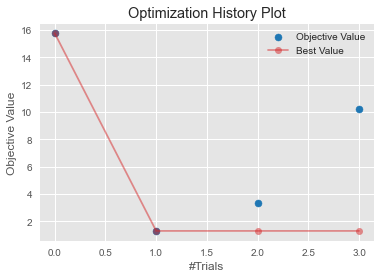

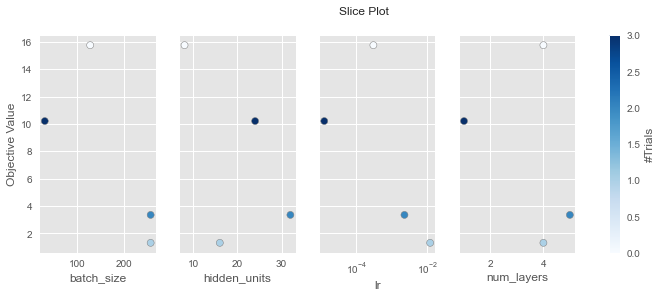

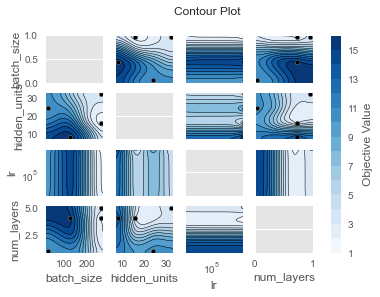

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
optuna.visualization.matplotlib.plot_contour(
    study, ["lr", "hidden_units", "num_layers", "batch_size"]
)